In [29]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import json

In [30]:
conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,27980,31506,35713,41035,47021,53578,59138,63927,69176,74386
62,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67798,67799,67800,67800,67800,67800,67800,67800,67801,67801
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,4632,6421,7783,13677,19100,25489,33276,43847,53740,65778
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,9942,11748,13910,17963,20410,25374,28768,35136,39885,49515
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323
133,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,6633,7652,9043,10871,12612,14282,16018,19856,22304,25233
206,NaN,Switzerland,46.8182,8.2275,0,0,0,0,0,0,...,2200,2700,3028,4075,5294,6575,7474,8795,9877,10897
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,1543,1950,2626,2689,3983,5018,5683,6650,8077,9529
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,8236,8320,8413,8565,8652,8799,8961,8961,9037,9137


In [31]:
for c in list(conf['Country/Region'].unique()):
    print(c)

Italy
China
US
Spain
Germany
Iran
France
Switzerland
United Kingdom
Korea, South
Netherlands
Austria
Belgium
Norway
Portugal
Brazil
Sweden
Turkey
Israel
Malaysia
Denmark
Czechia
Ireland
Canada
Luxembourg
Japan
Ecuador
Chile
Pakistan
Poland
Australia
Thailand
Romania
Saudi Arabia
Finland
Greece
Indonesia
Iceland
Diamond Princess
South Africa
Russia
India
Philippines
Singapore
Qatar
Slovenia
Peru
Colombia
Egypt
Panama
Croatia
Bahrain
Mexico
Estonia
Dominican Republic
Argentina
Serbia
Iraq
Lebanon
United Arab Emirates
Algeria
Lithuania
Armenia
Bulgaria
Taiwan*
Hungary
Morocco
Latvia
Slovakia
San Marino
New Zealand
Costa Rica
Kuwait
Uruguay
Andorra
North Macedonia
Bosnia and Herzegovina
Tunisia
Jordan
Moldova
Burkina Faso
Albania
Ukraine
Vietnam
Cyprus
Malta
Brunei
Sri Lanka
Senegal
Oman
Cambodia
Azerbaijan
Ghana
Venezuela
Belarus
Afghanistan
Kazakhstan
Cote d'Ivoire
Georgia
Cameroon
Uzbekistan
Trinidad and Tobago
Cuba
Montenegro
Liechtenstein
Nigeria
Mauritius
Congo (Kinshasa)
Kyrgyzstan


In [32]:
# Combine rows that correspond to the same country but different state/province

conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.drop(columns=['Province/State'], inplace=True)
cols = list(conf.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
conf_combined = conf.groupby(conf['Country/Region']).aggregate(agg)
conf_combined = conf_combined.sort_values(conf_combined.columns[-1], ascending=False)

In [33]:
deaths = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths = deaths.sort_values(conf.columns[-1], ascending=False)
deaths.drop(columns=['Province/State'], inplace=True)
cols = list(deaths.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
death_combined = deaths.groupby(conf['Country/Region']).aggregate(agg)
#death_combined = death_combined.sort_values(conf_combined.columns[-1], ascending=False)
death_combined = death_combined.reindex(conf_combined.index)

In [34]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
test.index
test.iloc[0,:]

1/22/20      548
1/23/20      643
1/24/20      920
1/25/20     1406
1/26/20     2075
           ...  
3/21/20    81305
3/22/20    81435
3/23/20    81498
3/24/20    81591
3/25/20    81661
Name: China, Length: 64, dtype: int64

In [35]:
"""Normalized growth rate

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing beween data points
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect
    
Returns 
-------
float
    1D array of growth rates'"""
def growth(arr, dx, padding='Same'):
    d = [None] * len(arr)
    for i in range(1, len(arr)-1):
        d[i] = (arr[i] - arr[i-1]) / dx
    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

"""2nd derivative finite difference (https://en.wikipedia.org/wiki/Five-point_stencil)

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing between data points (must be constant)
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect'
stencil_size : int
    size of stencil
    Option: 3, 5
    
Returns
-------
float
    1D array of finite differences
"""
def fd_2(arr, dx, padding='Same', stencil_size=3):
    d = [None] * len(arr)
    if stencil_size is 3:
        for i in range(1, len(arr)-1):
            d[i] = (arr[i-1] - 2*arr[i] + arr[i+1]) / dx
    elif stencil_size is 5:
        d[1] = (arr[0] - 2*arr[1] + arr[2]) / dx
        d[-2] = (arr[-3] - 2*arr[-2] + arr[-1]) / dx
        for i in range(2, len(arr) - 2):
            d[i] = (-arr[i-2] + 16*arr[i-1] - 30*arr[i] + 16*arr[i+1] - arr[i+2]) / 12

    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

In [36]:
def plotn(dates, df, delta_x, num_countries=1, title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    legend = df['Country/Region']
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for i in range(num_countries):
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[dr[0]:dr[1],i], label=legend[i])
    elif mode is 'growth':
        for i in range(num_countries):
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=legend[i])
    elif mode is 'deriv2':
        for i in range(num_countries):
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=legend[i])
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()
    
def plotc(dates, df, delta_x, countries=['US'], title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for c in countries:
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c][dr[0]:dr[1]], label=c)
    elif mode is 'growth':
        for c in countries:
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=c)
    elif mode is 'deriv2':
        for c in countries:
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same', 3)
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=c)
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()

In [49]:
def create_json(df_orig, title, delta_x=1):
    df = df_orig.drop(['Country/Region', 'Lat', 'Long'], axis=1)
    df_temp = df.copy()
    
    j_num_cases = df.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = growth(list(df.iloc[i,:]), delta_x, 'Same')
    j_growth = df_temp.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = fd_2(list(df.iloc[i,:]), delta_x, 'Same', 3)
    j_deriv2 = df_temp.to_json(orient='index')
    
    with open('{}_num_cases.json'.format(title), 'w') as f:
        json.dump(j_num_cases, f)
    with open('{}_growth.json'.format(title), 'w') as f:
        json.dump(j_growth, f)
    with open('{}_deriv2.json'.format(title), 'w') as f:
        json.dump(j_deriv2, f)

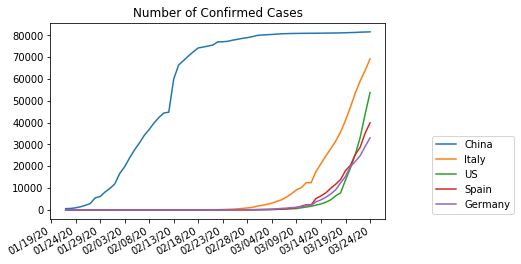

In [8]:
plotn(dates, conf_combined, 1, 5, mode='num_cases', title='Number of Confirmed Cases')

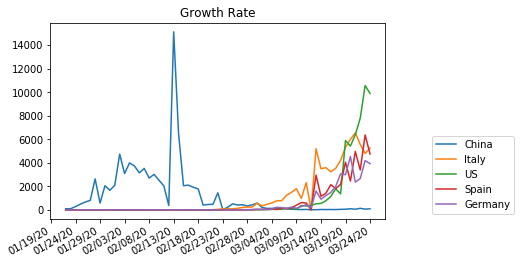

In [9]:
plotn(dates, conf_combined, 1, 5, title='Growth Rate', mode='growth')

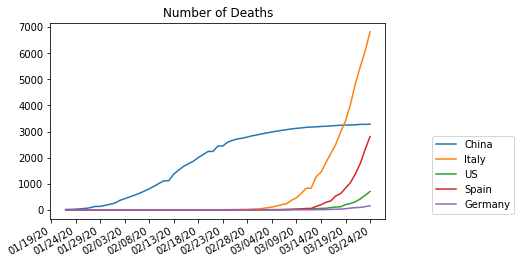

In [10]:
plotn(dates, death_combined, 1, 5, mode='num_cases', title='Number of Deaths')

In [11]:
mort = death_combined.copy()
mort.iloc[:,3:] = (mort.iloc[:,3:]/conf_combined.iloc[:,3:]).replace([np.inf, np.nan], 0)
mort.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,China,30.9756,112.2707,0.031022,0.027994,0.028261,0.029872,0.026988,0.028502,0.023779,...,0.039700,0.039848,0.039962,0.040034,0.040037,0.040084,0.040204,0.040173,0.040213,0.040227
Italy,Italy,43.0000,12.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.077127,0.079445,0.083387,0.082978,0.085749,0.090056,0.092597,0.095062,0.098589,0.100866
US,US,37.0902,-95.7129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018351,0.016820,0.015161,0.014623,0.012775,0.012044,0.012532,0.012703,0.013137,0.014321
Spain,Spain,40.0000,-4.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034400,0.045369,0.044788,0.046206,0.051102,0.054189,0.061596,0.065773,0.070402,0.073654
Germany,Germany,51.0000,9.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002338,0.002593,0.002271,0.002872,0.003376,0.003782,0.003779,0.004233,0.004760,0.005519


In [12]:
# Have to convert to numpy arrays here since pandas isn't dividing as expected

T = 7
mort2 = death_combined.iloc[:,np.r_[0:3,(3+T):len(death_combined.columns)]].copy() #Skip first T days
arr1 = mort2.iloc[:,3:].to_numpy()
arr2 = conf_combined.iloc[:,3:-T].to_numpy()
q = arr1/arr2
mort2.iloc[:,3:] = q
mort2.replace([np.inf, np.nan], 0)
mort2.head()

/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


,Country/Region,Lat,Long,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,China,30.9756,112.2707,0.242701,0.265941,0.231522,0.184211,0.173976,0.147723,0.089127,...,0.039785,0.039932,0.040051,0.040145,0.040188,0.040246,0.040418,0.040403,0.040477,0.040505
Italy,Italy,43.0000,12.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.235281,0.246625,0.238966,0.273231,0.228313,0.228057,0.221279,0.217191,0.216467,0.210092
US,US,37.0902,-95.7129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.145798,0.112617,0.092116,0.120265,0.111978,0.112578,0.119177,0.120250,0.109952,0.121033
Spain,Spain,40.0000,-4.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.318733,0.314454,0.273606,0.364515,0.199350,0.215146,0.227238,0.232448,0.239019,0.262185
Germany,Germany,51.0000,9.0000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,0.014456,0.016472,0.014675,0.021174,0.018231,0.018321,0.016221,0.016914,0.016960,0.016711


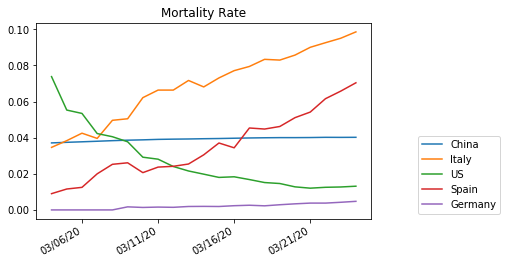

In [13]:
plotn(dates, mort, 1, 5, title='Mortality Rate', date_range=[-22,-1])

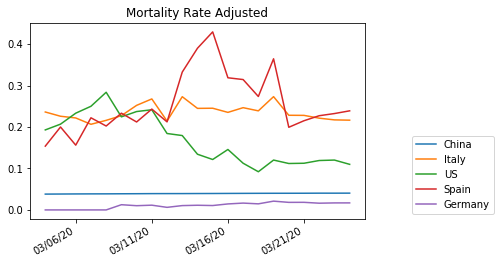

In [14]:
plotn(dates, mort2, 1, 5, title='Mortality Rate Adjusted', date_range=[-22,-1])

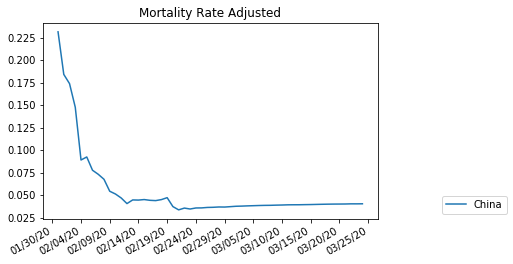

In [15]:
plotc(dates=dates, df=mort2, delta_x=1, countries=['China'], title='Mortality Rate Adjusted', date_range=[-55,-1])

In [50]:
create_json(conf_combined, 'confirmed')

In [43]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
len(list(test.iloc[0,:]))

64

In [46]:
len(growth(list(test.iloc[0,:]), dx=1))

64

In [44]:
len(test.index)

174

In [42]:
test.iloc[0,:] = growth(list(test.iloc[0,:]), dx=1)